Paul Graham is one of my favorite essayists. He is a software geek with a contrarian mentality to business and investing. His insights on startups and value creation during the internent paradigm are essential for anyone trying to understand how to found and/or invest in successful start up.  

Because I've found his essays so invaluable in forming my own perspective on startups and investings, particularly in this new paradigm of blockchain based applicaions, I wanted to do a textual analysis of his essays. Perhaps in doing so I can determine some of his writings characteristics, which contribute to its elegance and timelessness. 

In [3]:
from bs4 import BeautifulSoup, element
import re
import json
import pandas as pd
import nltk
import requests
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})

import warnings
warnings.filterwarnings('ignore')

Contents

- Acquistion
- Cleaning 
- Essay count and length over time
- Word frequency
- Part of speech tagging
- Introduction and concluding paragraphs

First we have crawl Paul Graham's [website](http://www.paulgraham.com/articles.html) to get the list of essays and their links. 

In [4]:
base_url = 'http://www.paulgraham.com/'
essay_url = base_url + 'articles.html'

essay_list_html = requests.get(essay_url).text
essay_list_soup = BeautifulSoup(essay_list_html, 'html5lib')
essay_links = essay_list_soup.find('tbody').find_all('a')[1:-1]
essays = pd.DataFrame([(a.text, a.attrs['href']) for a in essay_links], columns=['name','url'])

In [5]:
essays

,name,url
0,General and Surprising,sun.html
1,Charisma / Power,pow.html
2,The Risk of Discovery,disc.html
3,This Year We Can End the Death Penalty in Cali...,prop62.html
4,How to Make Pittsburgh a Startup Hub,pgh.html
5,Life is Short,vb.html
6,Economic Inequality,ineq.html
7,The Refragmentation,re.html
8,Jessica Livingston,jessica.html
9,A Way to Detect Bias,bias.html


We can see that he's written 178 essays. 

We'll want to drop those essays that are linked to external websites as they won't share the uniformity of the essay published on paulgraham.com

In [6]:
essays = essays[~essays.url.str.contains('https')]
essays.tail()

,name,url
171,Being Popular,popular.html
172,Java's Cover,javacover.html
173,Beating the Averages,avg.html
174,Lisp for Web-Based Applications,lwba.html
177,Programming Bottom-Up,progbot.html


In [7]:
len(essays)

176

Now lets get the essay bodies by fetching the contents of each essays url

In [8]:
def get_essay_body(essay_url):
    res = requests.get(base_url+essay_url).text
    soup = BeautifulSoup(res, 'html.parser')
    body = soup.find('body').find('font')
    return body.text

In [9]:
essays['text_raw'] = essays.url.apply(get_essay_body)

Lets additionally parse the date of these entries and look to see when Paul was most active in producing his essays:

In [10]:
essays['text'] = essays.text_raw

# get dates from essay body 
date_re = '((Jan(uary)?|Feb(ruary)?|Mar(ch)?|Apr(il)?|May|Jun(e)?|Jul(y)?|Aug(ust)?|Sep(tember)?|Oct(ober)?|Nov(ember)?|Dec(ember)?)(\s+\d{4}))'
dates = essays.text.str.extract(date_re)[0]
essays['date'] = dates.apply(lambda d: datetime.strptime(d, '%B %Y') if isinstance(d, str) else None)

# remove publish date from start of essay
date_pattern = re.compile(date_re)
essays['text'] = essays.text.apply(lambda t: t[date_pattern.search(t).span()[1]:] if date_pattern.search(t) else t)

# add padding to text so as to not concatenate the beginning and ending words of different essays when grouped
essays['text'] = essays.text.str.ljust(1, ' ')

# remove new lines from text 
essays['text'] = essays.text.str.replace('\n', ' ')

def get_paragraphs(t):
    new_paragraph_pattern = re.compile('(\w{2}|\)\])(\.\w)')
    markers = [''.join(r) for r in new_paragraph_pattern.findall(t)]
    for marker in markers: 
        end, start = marker.split('.')
        t = t.replace(marker, end + '.\n\n' + start)
    return t

essays['text'] = essays.text.apply(get_paragraphs)

def remove_notes(t):
    search_results = t.find('Notes[1]')
    if search_results == -1:
        return t
    else:
        return t[:search_results]

essays['text'] = essays.text.apply(remove_notes)


We group by month, year and decade:

In [11]:
by_year = essays.groupby(essays.date.dt.year)
by_decade = essays.groupby(essays.date.dt.year // 10 * 10)
by_month = essays.groupby([essays.date.dt.year, essays.date.dt.month])

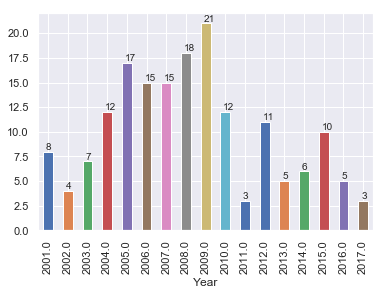

In [12]:
ax = by_year.size().plot.bar()
ax.set_xlabel('Year')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+.15, p.get_height()+.2))

So it seems like he was most active in writing during the mid to late 2000's, peaking in 2009 with just over 20 essays. 

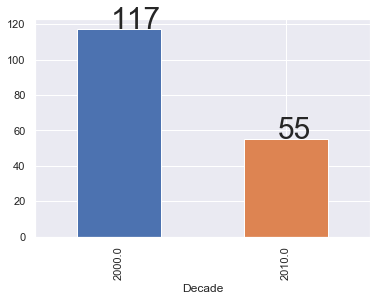

In [13]:
ax = by_decade.size().plot.bar()
ax.set_xlabel('Decade')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+.2, p.get_height()+.3), fontsize=30)

In [14]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.text import Text
from nltk.corpus import stopwords
from nltk.corpus import wordnet

### Tokenization

Tokenization is the process of breaking up a corpus into smaller chunks or units. Those units can be words, sentences, and paragaphs. We'll tokenize each essay and get the counts for each type of token. 

Let's start with paragraphs as that will be the easiest:

In [15]:
essays['paragraph_count'] = essays.text.apply(lambda t: len(t.split('\n\n')))

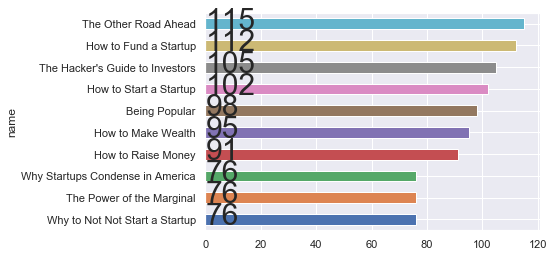

In [16]:
ax = essays.set_index('name').paragraph_count.sort_values().tail(10).plot(kind='barh')
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_x()+.2, p.get_y()), fontsize=30)

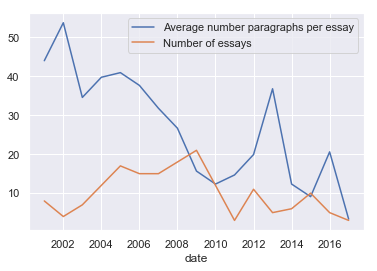

In [17]:
by_year = essays.groupby(essays.date.dt.year)
by_year.paragraph_count.mean().plot(label='Average number paragraphs per essay')
by_year.text.count().plot(label='Number of essays')
plt.legend()

When we plot the average paragraph count by year we see that over time Paul Graham has written increasingly shorter essays. Perhaps this concision results from having learned how to more clearly get his point across with fewer words. 
Or perhaps in an effort to cover more subjects he has compromised the depth with which he goes into a given topic. We can see that throughout the 2000's the number of essays written increases while the average number paragraphs falls. 

While there is a decline in the number of essays written over the past decade we do see spike in average number of paragraphs in 2013 to levels comparable to those during the 2000's. 

Lets look now at sentences:


In [18]:
essays['sentence_count'] = essays.text.apply(lambda t: len(sent_tokenize(t)))
essays['sentences_per_paragraph'] = essays.sentence_count / essays.paragraph_count

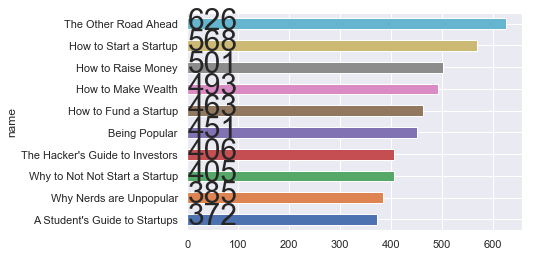

In [19]:
ax = essays.set_index('name').sentence_count.sort_values().tail(10).plot(kind='barh')
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_x()+.2, p.get_y()), fontsize=30)

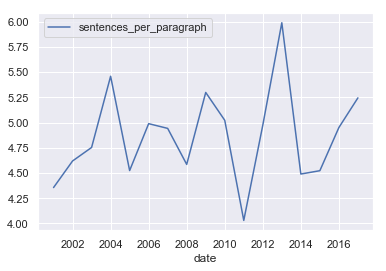

In [20]:
by_year = essays.groupby(essays.date.dt.year)
by_year.sentences_per_paragraph.mean().plot()
plt.legend()

Paul seems to consistently write paragraphs with around 4 to 5 sentences long. 

Next we'll tokenize the words within an essay. We'll start by using the longest essay in the collection, "The Other Road Ahead":

In [24]:
t = essays.set_index('name').loc['The Other Road Ahead'].text.lower()

# remove symbols that won't be seperated out by our split
symbols_to_remove = ['.',',',')','(','[',']', '\n']
for s in symbols_to_remove:
    t = t.replace(s, ' ')

sw = stopwords.words('english')
words = [w for w in t.split(' ') if w != '']
tokens = [w for w in words if w not in sw]

When we remove stop words from our tokenization we get rid of nearly half the words present in the essay. 

In [25]:
len(words), len(tokens)

(10784, 5447)

Let's look at the freq with which words appear in this essay:

In [26]:
t = Text(tokens)

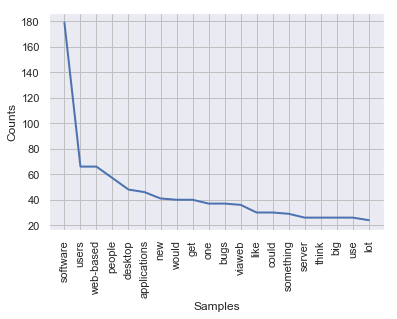

In [27]:
t.plot(20)

The number one word used by a long shot is "software." This makes a lot of sense since the article is meant to explain how the web will change the next generation of software companies. 

In [28]:
grouped_essays = essays[['date','name','text']].groupby(essays.date.dt.year//10*10).sum()

In [29]:
def tokenize(corpus, stem_words=False, remove_stop_words=False, tokenize_sent=False):
    corpus = corpus.lower()
    
    symbols_to_remove = [')','(','[',']', '\n']
    
    for s in symbols_to_remove:
        corpus = corpus.replace(s, ' ')

    sw = stopwords.words('english')
    
    if tokenize_sent:
        tokens = [[w for w in sent.split(' ') if w !=''] for sent in sent_tokenize(corpus)]
    else:
        tokens = [[w for w in corpus.split(' ') if w != '']]

    if remove_stop_words:
        tokens = [[w for w in words if w not in sw] for words in tokens]
    
    if stem_words:
        tokens = [[stemmer.stem(w) for w in words] for words in tokens]
    
    return tokens

In [60]:
decade_text = {}

for decade in grouped_essays.index:
    decade = int(decade)
    tokens = tokenize(grouped_essays.loc[decade].text)
    decade_text[decade] = {}
    #decade_text[decade]['all_words'] = Text(words)
    decade_text[decade]['tokens'] = Text(tokens[0])
    #decade_text[decade]['stemmed_tokens'] = Text(stemmed_tokens)
    

In [61]:
d = list(decade_text.values())[0]['tokens']

In [62]:
d.concordance('like')

Displaying 25 of 25 matches:
this route your ideas will seem a lot like ones that already exist. sometimes yo
ozer. and yet the builder-type ceo is like hillary probably the best person for 
ue here. the real world does not work like the version i was shown on tv growing
o make pittsburgh into a startup hub, like silicon valley? i feel like i underst
rtup hub, like silicon valley? i feel like i understand pittsburgh pretty well, 
n the boring suburbs. so whether they like it or not, founders know they have to
. when cities are on the way back up, like pittsburgh is now, developers race to
es, but the neighborhoods they're in. like san francisco and new york, pittsburg
cause those 25 to 29 year olds do not like driving. they prefer walking, or bicy
 you'll regret it. the city will seem like a paradise to the young people you wa
rld, but imagine what things would be like if it were the very best, and everyon
ies be setting up programs with words like "innovation" and "entrepreneurship" i

In [32]:
most_used = pd.DataFrame(decade_text[2000]['tokens'].vocab().most_common(25), columns=['stem','tally'])
most_used['pct'] = most_used.tally / len(decade_text[2000]['stemmed_tokens'].tokens)
most_used

TypeError: unhashable type: 'list'

In [ ]:
for rank, word in most_used.head(10).iterrows():
    print(word.stem)
    print()
    decade_text[2010]['all_words'].concordance(word.stem, width=50, lines=5)

In [ ]:
most_used = pd.DataFrame(decade_text[2010]['stemmed_tokens'].vocab().most_common(25), columns=['name','tally'])
most_used['pct'] = most_used.tally / len(decade_text[2000]['stemmed_tokens'].tokens)
most_used

We can see that during the 2000's Pauls focus is more on explaining how to create a successful startup, which entails *working* to *make* *something* that *people* *want* and *like* to *use*

In [ ]:
nltk.version_info

In [ ]:
c = decade_text[2000]['all_words'].concordance('one')

In [ ]:
c[0]

In [ ]:
d = decade_text[2000]
d.concordance(one)

### Part of speech tagging

In [34]:
grouped_essays = essays[['date','name','text']].groupby(essays.date.dt.year//1000).sum()
corpus = grouped_essays.text.values[0]

In [35]:
tokens = tokenize(corpus, remove_stop_words=True)

In [36]:
tags = nltk.pos_tag(tokens[0])

In [37]:
tags[:10]

[('valuable', 'JJ'),
 ('insights', 'NNS'),
 ('general', 'JJ'),
 ('surprising.', 'NN'),
 ('f\xa0=\xa0ma', 'NN'),
 ('example.', 'VBZ'),
 ('general', 'JJ'),
 ('surprising', 'JJ'),
 ('hard', 'JJ'),
 ('combination', 'NN')]

In [38]:
tag_df = pd.DataFrame(tags, columns=['word','pos'])
tag_df.head()

,word,pos
0,valuable,JJ
1,insights,NNS
2,general,JJ
3,surprising.,NN
4,f = ma,NN


In [39]:
gb = tag_df.groupby('pos')
gb.word.value_counts().to_frame()

word
pos word               
$   "web              3
    mid               2
    x                 2
    "issues."         1
    $x/2.             1
    *                 1
    .05/1.05,         1
    ``act''           1
    bargain.          1
    better.           1
    drink             1
    equity.           1
    europe            1
    experience.       1
    google            1
    grandmas          1
    head.             1
    italy             1
    kant.             1
    loading.          1
    macros?           1
    mba.              1
    min               1
    minicomputer.     1
    more.             1
    munich.           1
    noise.            1
    october           1
    orange.           1
    peace.            1
...                 ...
WP  weight,           1
    wherever          1
    whichever         1
    white.            1
    who've            1
    why?              1
    words.            1
    work.             1
    yc                1
WP$ whose            81
WRB whenever         16
    we're             2
    wherever          2
    work.             2
    binary,           1
    wait.             1
    want.             1
    washington.       1
    way.              1
    what's            1
    what.             1
    whatsoever        1
    who'd             1
    why?              1
    winners.          1
    wish              1
    work,             1
    world's           1
    world.            1
    write             1

[39814 rows x 1 columns]

In [40]:
verbs = tag_df[tag_df.pos.str.contains('VB')]
verb_counts = verbs.word.value_counts(ascending=True)
verb_counts.where((verb_counts<10)&(verb_counts>1))

detached            NaN
intelligence,       NaN
formality;          NaN
condense,           NaN
gimmicks.           NaN
consolidated        NaN
logos.              NaN
play.               NaN
dangerous,          NaN
overhung            NaN
handholding         NaN
fossilized          NaN
fearsome.           NaN
juicy               NaN
shocked             NaN
failure,            NaN
publishing—giving   NaN
unexamined          NaN
expertise           NaN
advantages:         NaN
vegas.              NaN
fear.               NaN
constraints.        NaN
shelves.            NaN
structuring         NaN
spare               NaN
x."                 NaN
addressed           NaN
counterargument.    NaN
cambridge           NaN
                     ..
tell                NaN
done                NaN
work                NaN
tend                NaN
getting             NaN
starting            NaN
trying              NaN
got                 NaN
making              NaN
start               NaN
means           

In [41]:
verb_counts[(verb_counts<3)&(verb_counts>1)]

concept           2
worthless         2
varied            2
would,            2
provoke           2
pets.             2
store             2
fame              2
stop.             2
accomplish        2
angels            2
generally.        2
month.            2
printing          2
controls          2
overestimating    2
notes             2
overloaded        2
outsider,         2
valid             2
wear              2
short             2
pandering         2
brains            2
erann             2
reflecting        2
much,             2
terrible,         2
succinct          2
long,             2
                 ..
automate          2
optimization.     2
poor,             2
fund?             2
zooming           2
favored           2
hemmed            2
statement,        2
stressful,        2
smaller,          2
intelligence      2
english           2
heads.            2
delight           2
everyone.         2
default.          2
weighing          2
erred             2
grab              2


In [42]:
tag_df.head(20)

,word,pos
0,valuable,JJ
1,insights,NNS
2,general,JJ
3,surprising.,NN
4,f = ma,NN
5,example.,VBZ
6,general,JJ
7,surprising,JJ
8,hard,JJ
9,combination,NN


In [43]:
tag_df.pos.value_counts()

NN      63761
JJ      39482
NNS     19115
RB      13993
VBP     13980
VBG      7816
VB       6793
VBD      6232
CD       5063
IN       3970
VBZ      3737
VBN      3354
MD       3156
JJR       959
JJS       919
NNP       731
RBR       662
DT        520
PRP       330
CC        245
WDT       204
RP        178
FW        178
,         108
WP$        81
WP         73
RBS        60
.          51
$          48
WRB        38
:          33
UH         11
(           7
)           5
EX          4
SYM         3
PDT         2
POS         2
NNPS        1
''          1
Name: pos, dtype: int64

Useful links
- https://pythonspot.com/category/nltk/
- https://likegeeks.com/nlp-tutorial-using-python-nltk/
- https://github.com/hb20007/hands-on-nltk-tutorial
- https://www.slideshare.net/japerk/nltk-in-20-minutes